# Framingham Heart Disease Risk Study
 ## Modeling, Hyperparameter Tuning and Best Model Selection

In [51]:
from autogluon.tabular import TabularPredictor, TabularDataset

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, \
                            roc_auc_score, roc_curve, auc,\
                            confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, \
                            precision_recall_curve, \
                            mean_absolute_error, mean_squared_error, r2_score, \
                            f1_score, precision_score, recall_score, make_scorer


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet, SGDClassifier, SGDRegressor, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization

import joblib
import os

In [52]:
# View the confusion matrix for the model and store the recall and precision scores
recall_scores = {}
precision_scores = {}
TP_dict, FP_dict, FN_dict, TN_dict = {}, {}, {}, {}

def plot_cm_pr(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    TP, FP, FN, TN = cm[1, 1], cm[0, 1], cm[1, 0], cm[0, 0]
    TP_dict[model_name], FP_dict[model_name], FN_dict[model_name], TN_dict[model_name] = TP, FP, FN, TN

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    recall_scores[model_name] = recall
    precision_scores[model_name] = precision
    
    print(f'Recall for {model_name}: {recall:.4f}')
    print(f'Precision for {model_name}: {precision:.4f}')
    
    # Plot the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

In [53]:
# Load data
df = pd.read_csv("../data/processed/df_imput_dummy_scaled.csv")
df.shape

(4238, 20)

In [54]:
# Create a dictionary to store the recall scores for each model
recall_scores = {}

In [55]:
# Train test split of the df
X_train, X_test, y_train, y_test = train_test_split(df.drop('TenYearCHD', axis=1), df['TenYearCHD'], test_size=0.2, random_state=42)

# Save train and test dataframes
# train_data.to_csv('../data/processed/df_dummy_scaled_train.csv', index=False)
# test_data.to_csv('../data/processed/df_dummy_scaled_test.csv', index=False)

# Train-test split df to two dataframes df_train and df_test
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

train_data = TabularDataset(df_train)
test_data = TabularDataset(df_test)

In [56]:
# Create a dict of already trained models
models = {}

# Define model paths
models_folder = '../models'
model_paths = {
    # 'NeuralNetFastAI_BAG_L1': f'{models_folder}/NeuralNetFastAI_BAG_L1/model.pkl',
    # 'KMeans': f'{models_folder}/KMeans.pkl',
    'Logistic Regression': f'{models_folder}/logistic_regression_model.pkl',
    '_imp Logistic Regression Balanced Best': f'{models_folder}/_imp_logistic_regression_balanced_best.pkl',
    '_imp SVM Balanced Best': f'{models_folder}/_imp_svm_balanced_best.pkl',
    # 'SVM Balanced Best Precision': f'{models_folder}/svm_balanced_best_precision.pkl',
    '_imp SVM Balanced BayesOpt': f'{models_folder}/_imp_svm_balanced_optimized.pkl',
    # 'XGBoost Balanced Best': f'{models_folder}/xgboost_balanced_best.pkl',
}

# Load models in the dict
for model_name, model_path in model_paths.items():
    model = joblib.load(model_path)
    models[model_name] = model

## AutoGluon

In [57]:
# Use AutoGluon to train a model (target column is 'TenYearCHD')
'''
if 'NeuralNetFastAI_BAG_L1' in models:
    print('Model already trained!')
    model_name = 'NeuralNetFastAI_BAG_L1'
    model = models[model_name]
    print(model)

else:
    predictor = TabularPredictor(label='TenYearCHD', eval_metric='recall').fit(train_data, auto_stack=True)
    distilled_model_names = predictor.distill(train_data=train_data, tuning_data=train_data)
    print(distilled_model_names)
    
    ldr = predictor.leaderboard(test_data)

    model = ldr.loc[ldr['eval_metric'] == 'recall'].reset_index(drop=True).iloc[0]
    model_name = model['model']

    print(model)
'''

"\nif 'NeuralNetFastAI_BAG_L1' in models:\n    print('Model already trained!')\n    model_name = 'NeuralNetFastAI_BAG_L1'\n    model = models[model_name]\n    print(model)\n\nelse:\n    predictor = TabularPredictor(label='TenYearCHD', eval_metric='recall').fit(train_data, auto_stack=True)\n    distilled_model_names = predictor.distill(train_data=train_data, tuning_data=train_data)\n    print(distilled_model_names)\n    \n    ldr = predictor.leaderboard(test_data)\n\n    model = ldr.loc[ldr['eval_metric'] == 'recall'].reset_index(drop=True).iloc[0]\n    model_name = model['model']\n\n    print(model)\n"

In [58]:
# View the confusion matrix for the model
# plot_cm_pr(model, X_test, y_test, model_name)

## Compare with the best tuned Logistic Regression model

In [59]:
# Load the best Logistic Regression model
log_reg_best = models['Logistic Regression']
log_reg_best

LogisticRegression(C=0.004832930238571752, penalty='l1', solver='liblinear')

/opt/anaconda3/envs/AutoGluon/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


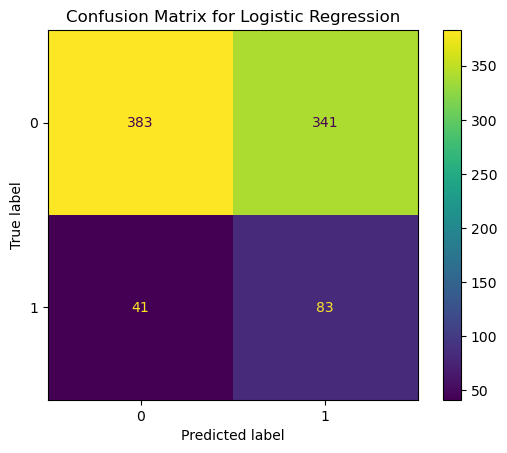

Recall for Logistic Regression: 0.6694
Precision for Logistic Regression: 0.1958


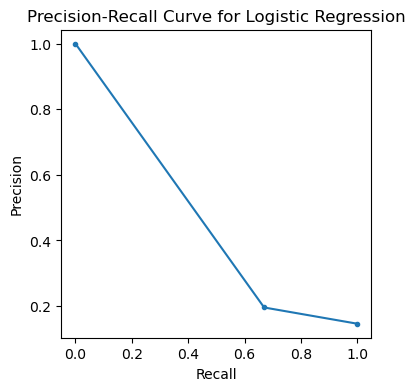

In [60]:
plot_cm_pr(log_reg_best, X_test, y_test, 'Logistic Regression')

### Train find hyperparameters for another LogReg model with class_weight='balanced' on the unbalanced dataset.

In [62]:
best_logreg_model_name = '_imp Logistic Regression Balanced Best'

if best_logreg_model_name in models:
    print('Model already trained!')
    
    model_name = best_logreg_model_name
    model = models[model_name]
    print("Model Loaded!")

else:
    print("Training the Logistic Regression model with balanced class weights...")
    # Define the model
    log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42)

    # Define the hyperparameters for random search
    param_dist = {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
    }

    # Define the random search
    rs = RandomizedSearchCV(log_reg_balanced, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42, scoring='recall')

    # Fit the random search
    rs.fit(X_train, y_train)
    
    model = rs.best_estimator_
    models[best_logreg_model_name] = model

    # Save the model
    joblib.dump(model, f'{models_folder}/_imp_logistic_regression_balanced_best.pkl')
    print(f"Model saved as {models_folder}/_imp_logistic_regression_balanced_best.pkl")


model

Model already trained!
Model Loaded!


LogisticRegression(C=0.00026366508987303583, class_weight='balanced',
                   random_state=42, solver='liblinear')

In [63]:
model = joblib.load(f'{models_folder}/_imp_logistic_regression_balanced_best.pkl')
model_name = best_logreg_model_name

# add the model to the models dict
models[model_name] = model

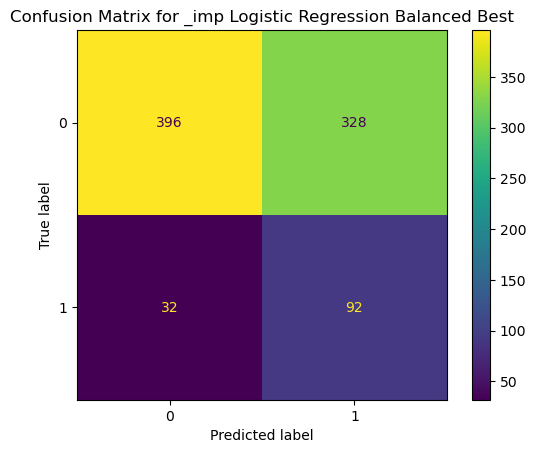

Recall for _imp Logistic Regression Balanced Best: 0.7419
Precision for _imp Logistic Regression Balanced Best: 0.2190


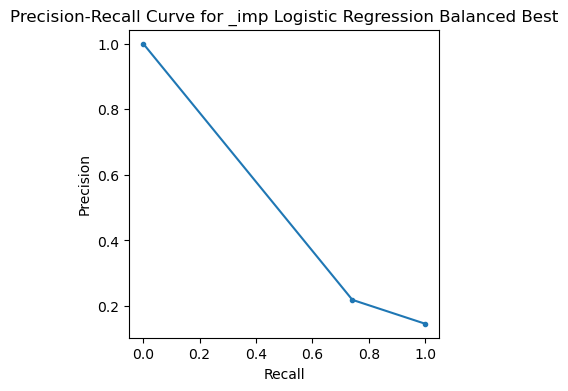

In [64]:
plot_cm_pr(model, X_test, y_test, best_logreg_model_name)

# SVM with balanced class weights

In [65]:
if '_imp SVM Balanced Best' in models:
    print('Model already trained!')
    
    model_name = '_imp SVM Balanced Best'
    model = models[model_name]
    print("Model Loaded!")

else:
    print("Training the SVM model with balanced class weights...")
    # Fit and find the best parameters for the SVM model with balanced class weights
    svm_balanced = SVC(class_weight='balanced', probability=True, random_state=42)

    param_dist = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    }

    rs = RandomizedSearchCV(svm_balanced, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42, scoring='recall')

    rs.fit(X_train, y_train)

    # Get the best model
    best_svm_model = rs.best_estimator_
    # Get the best model name
    best_svm_model_name = '_imp SVM Balanced Best'
    best_svm_params = rs.best_params_

    # Save the best SVM model
    joblib.dump(best_svm_model, '../models/_imp_svm_balanced_best.pkl')
    
model

Model already trained!
Model Loaded!


SVC(C=0.1, class_weight='balanced', gamma=1, probability=True, random_state=42)

In [66]:
model = joblib.load('../models/_imp_svm_balanced_best.pkl')
model_name = '_imp SVM Balanced Best'
# Add the model to the models dict
models['_imp SVM Balanced Best'] = model

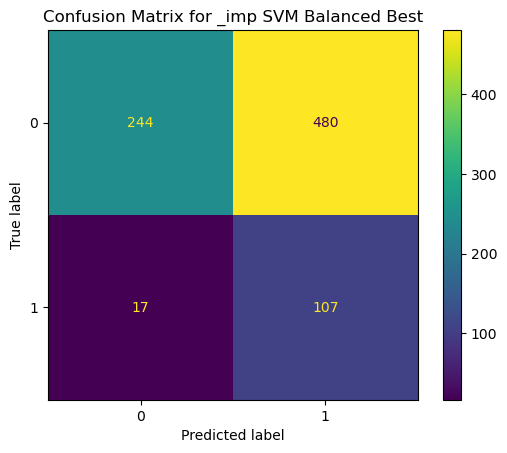

Recall for _imp SVM Balanced Best: 0.8629
Precision for _imp SVM Balanced Best: 0.1823


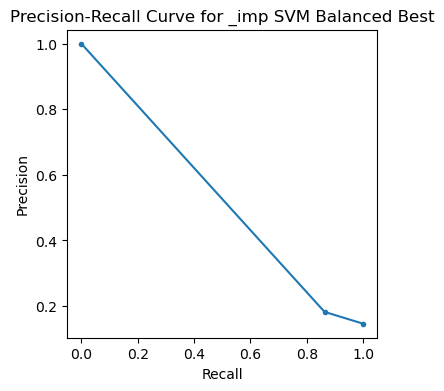

In [67]:
plot_cm_pr(model, X_test, y_test, model_name)

## Bayesian Optimization for the SVM model

In [68]:
# Bayesian Optimization for the SVM model with balanced class weights
def optimize_svm_balanced(C, gamma):
    model = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True, random_state=42)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
    return scores.mean()

In [69]:
if '_imp SVM Balanced BayesOpt' in models:
    print('Model already trained!')
    
    model_name = '_imp SVM Balanced BayesOpt'
    model = models[model_name]
    print("Model Loaded!")

else:
    # Define the parameter space
    pbounds = {
        'C': (7, 20),
        'gamma': (0.001, 1)
    }

    # Perform the optimization
    optimizer = BayesianOptimization(f=optimize_svm_balanced, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=10, n_iter=100)
    
    # Get the best parameters
    best_params = optimizer.max['params']
    print(optimizer.max)
    
    # Fit the model with the best parameters
    best_svm_model_optimized = SVC(C=best_params['C'], gamma=best_params['gamma'], class_weight='balanced', probability=True, random_state=42)
    best_svm_model_optimized.fit(X_train, y_train)
    
    # Save the best SVM model
    model_name = '_imp SVM Balanced BayesOpt'
    joblib.dump(best_svm_model_optimized, '../models/_imp_svm_balanced_optimized.pkl')
    
    model = best_svm_model_optimized

Model already trained!
Model Loaded!


In [70]:
model = joblib.load('../models/_imp_svm_balanced_optimized.pkl')
model_name = '_imp SVM Balanced BayesOpt'
# Add the model to the models dict
models['_imp SVM Balanced BayesOpt'] = model

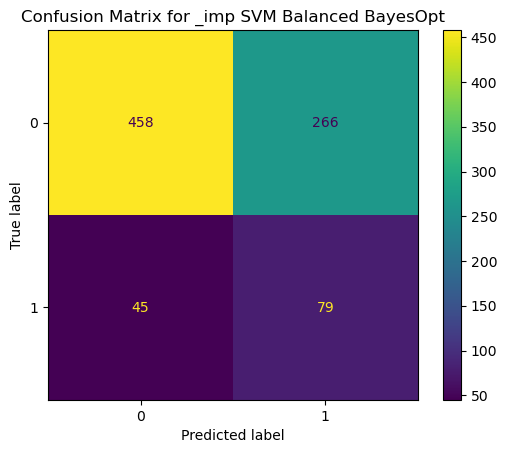

Recall for _imp SVM Balanced BayesOpt: 0.6371
Precision for _imp SVM Balanced BayesOpt: 0.2290


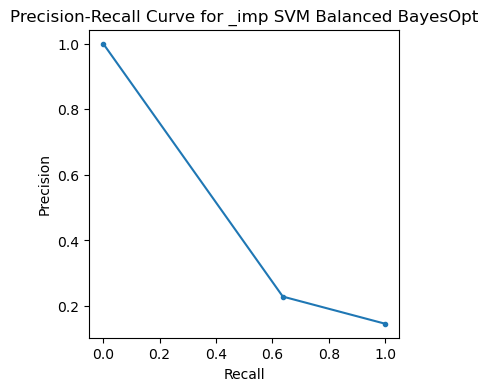

In [72]:
plot_cm_pr(model, X_test, y_test, model_name)

# Summary

## Best model based on the Recall
- The best model based on the Recall (Sensitivity) is `SVM Balanced Best`, which is a hypertuned SVM, trained with balanced class weights.

- Next best is `Logistic Regression Balanced Best`, which is a hypertuned Logistic Regression model, trained with balanced class weights.

...(see the chart below)

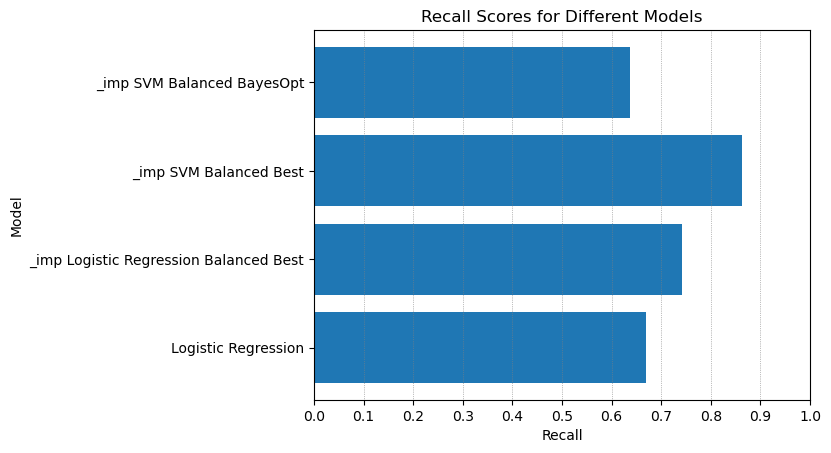

In [73]:
# horizontal bar plot
plt.barh(list(recall_scores.keys()), list(recall_scores.values()))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='x', color='gray', linestyle=':', linewidth=0.5)
plt.xlabel('Recall')
plt.ylabel('Model')
plt.title('Recall Scores for Different Models')
plt.show()

## Confusion Matrices
- As seen on the confusion matrices, the best model in terms of minimizing False Negatives and maximizing True Positives is again `SVM Balanced Best`.
- Next best is again `Logistic Regression Balanced Best`.
...(see below)

/opt/anaconda3/envs/AutoGluon/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


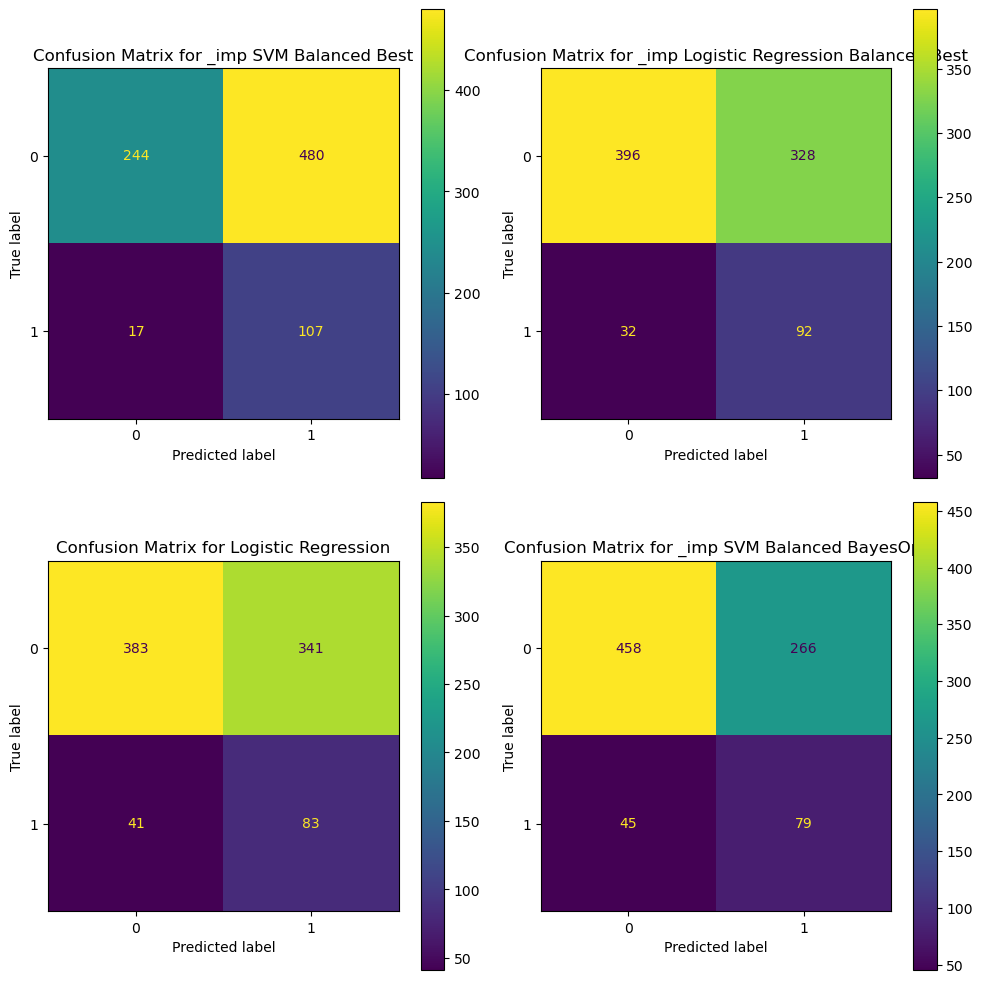

In [74]:
# Four best models based on recall score
best_models = sorted(recall_scores, key=recall_scores.get, reverse=True)[:4]

# Plot the confusion matrix for the best models 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, model_name in enumerate(best_models):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(values_format='d', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Confusion Matrix for {model_name}')
plt.tight_layout()
plt.show()

## Choosing the best model
While we want to minimize the False Negatives for any screening test, our goal is also to minimize False Positives in order to lower the rate of patients' false alarms (as good as possible, not lowering the Screening power). Let's create a new table with calculated metrics and see if we can spot a good candidate.

In [75]:
summary_df = pd.DataFrame(recall_scores.items(), columns=['Model', 'Recall'])
summary_df['Precision'] = summary_df['Model'].map(precision_scores)

summary_df['TP'] = summary_df['Model'].map(TP_dict)
summary_df['FP'] = summary_df['Model'].map(FP_dict)
summary_df['FN'] = summary_df['Model'].map(FN_dict)
summary_df['TN'] = summary_df['Model'].map(TN_dict)

summary_df['Specificity (TNR)'] = summary_df['TN'] / (summary_df['TN'] + summary_df['FP'])
summary_df['MCC'] = (summary_df['TP'] * summary_df['TN'] - summary_df['FP'] * summary_df['FN']) / np.sqrt((summary_df['TP'] + summary_df['FP']) * (summary_df['TP'] + summary_df['FN']) * (summary_df['TN'] + summary_df['FP']) * (summary_df['TN'] + summary_df['FN']))
summary_df['F1 Score'] = 2 * (summary_df['Recall'] * summary_df['Precision']) / (summary_df['Recall'] + summary_df['Precision'])
summary_df['Balanced Accuracy'] = (summary_df['Recall'] + summary_df['Specificity (TNR)']) / 2
summary_df['Average Precision'] = summary_df['Recall'] * summary_df['Precision']

# Rename Recall columns to Sensitivity
summary_df = summary_df.rename(columns={'Recall': 'Sensitivity (Recall)',
                            'Precision': 'PPV (Precision)'})

# Column order
summary_df = summary_df[['Model', 'TP', 'FP', 'FN', 'TN', 'Sensitivity (Recall)', 'PPV (Precision)', 'Specificity (TNR)', 'Balanced Accuracy', 'F1 Score', 'MCC', 'Average Precision']]

In [76]:
# Sort the summary dataframe by Recall
summary_df = summary_df.sort_values(by='Sensitivity (Recall)', ascending=False)

summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886


Table above shows the models sorted by Recall (as before). 

Below,let's sort each column.

In [77]:
# Sort the summary dataframe by PPV
summary_df = summary_df.sort_values(by='PPV (Precision)', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292


In [78]:
# Sort the summary dataframe by Specificity
summary_df = summary_df.sort_values(by='Specificity (TNR)', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292


In [79]:
# Sort the summary dataframe by Balanced Accuracy
summary_df = summary_df.sort_values(by='Balanced Accuracy', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029


In [80]:
# Sort the summary dataframe by F1 Score
summary_df = summary_df.sort_values(by='F1 Score', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292


In [81]:
# Sort the summary dataframe by MCC
summary_df = summary_df.sort_values(by='MCC', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029


In [82]:
# Sort the summary dataframe by Average Precision
summary_df = summary_df.sort_values(by='Average Precision', ascending=False)
summary_df.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1)

,Model,TP,FP,FN,TN,Sensitivity (Recall),PPV (Precision),Specificity (TNR),Balanced Accuracy,F1 Score,MCC,Average Precision
1,_imp Logistic Regression Balanced Best,92,328,32,396,0.741935,0.219048,0.546961,0.644448,0.338235,0.204163,0.162519
2,_imp SVM Balanced Best,107,480,17,244,0.862903,0.182283,0.337017,0.599960,0.300985,0.153037,0.157292
3,_imp SVM Balanced BayesOpt,79,266,45,458,0.637097,0.228986,0.632597,0.634847,0.336887,0.193980,0.145886
0,Logistic Regression,83,341,41,383,0.669355,0.195755,0.529006,0.599180,0.302920,0.140175,0.131029


In [83]:
# Create a df for the rating of the models based on the index of sorted summary_df by each metric
metrics = ['Sensitivity (Recall)', 'PPV (Precision)', 'Specificity (TNR)', 'Balanced Accuracy', 'F1 Score', 'MCC', 'Average Precision']
model_list = summary_df['Model'].tolist()
rating_df = pd.DataFrame(index=metrics, columns=model_list)

for metric in metrics:
    sorted_df = summary_df.sort_values(by=metric, ascending=False).reset_index(drop=True)
    model_rating = sorted_df['Model'].to_dict()
    for key, value in model_rating.items():
        rating_df.loc[metric, value] = key + 1

rating_df

,_imp Logistic Regression Balanced Best,_imp SVM Balanced Best,_imp SVM Balanced BayesOpt,Logistic Regression
Sensitivity (Recall),2,1,4,3
PPV (Precision),2,4,1,3
Specificity (TNR),2,4,1,3
Balanced Accuracy,1,3,2,4
F1 Score,1,4,2,3
MCC,1,3,2,4
Average Precision,1,2,3,4


In [84]:
# Get the model with the best average rank
rating_df.mean().sort_values()

_imp Logistic Regression Balanced Best    1.428571
_imp SVM Balanced BayesOpt                2.142857
_imp SVM Balanced Best                         3.0
Logistic Regression                       3.428571
dtype: object

The best ranking model across different statistics is `SVM Balanced Bayes OPT`, but it was on the last place ranking by Recall (which we are trying to focus on)

The next best model is, again `Logistic Regression Balanced Best', which ranked 2nd at almost every metric. It is 4th based on the Specificity Rank, but this metric is not crucial. Also it was ranked 1st in Average Precision, which is definitely great.

So, based on our study, we can verify that the tuned Logistic Regression model with balanced class weights (`Logistic Regression Balanced Best`) performs the best across trained models.

### Finally, let's compare the model trained on dropped dataset and on imputed dataset!

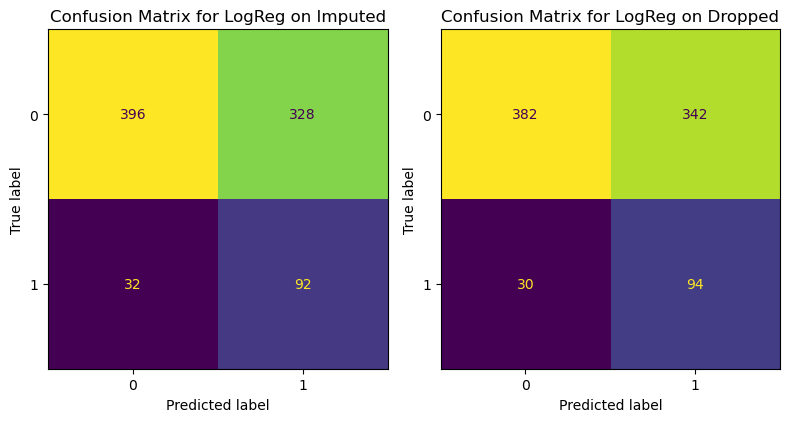

In [102]:
# load models
logreg_imp = joblib.load('../models/_imp_logistic_regression_balanced_best.pkl')
logreg_drop = joblib.load('../models/logistic_regression_balanced_best.pkl')

# Get model performances and compare them
logreg_imp_performance = classification_report(y_test, logreg_imp.predict(X_test))
logreg_drop_performance = classification_report(y_test, logreg_drop.predict(X_test))

best_logreg_models = {"LogReg on Imputed" : logreg_imp, "LogReg on Dropped" : logreg_drop}

# Plot the confusion matrix for the best models 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(8, 10))
i=0
for name, model in best_logreg_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(values_format='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].images[-1].colorbar.remove()
    i+=1
plt.tight_layout()
plt.show()

# Final Model
`Logistic Regression Balanced Best` - trained on the dataset with dropped missing values.